# AUC MAP

In [82]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
import numpy as np
import sklearn.metrics as metrics
import random

from os import path
import tqdm

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from custom_data_set import test_dir
from torch.utils.data import DataLoader

from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention
from attention_algorithms.attention_visu import hightlight_txt
from attention_algorithms.attention_metrics import default_plot_colormap
from attention_algorithms.attention_metrics import attention_score
from attention_algorithms.attention_visu import construct_html_table
from attention_algorithms.attention_visu import construct_html_page_visu

# --> display beautiful graphs
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, "auc_head_map")
if not path.exists(path.join(plots_folder, "auc_head_map")):
    os.mkdir(path.join(plots_folder, "auc_head_map"))

print(f">> the plots location : {graph_folder}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\auc_head_map


In [2]:
# load the model

ckp = path.join(".cache", "logs", "igrida_trained", "0", "best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertNliLight(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [4]:
# load the data
data_set = SnliDataset(dir=test_dir, nb_sentences=1000, msg=False)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

print(f">> shape of the sentences : {sentences.shape}")
print(f">> shape of the masks : {masks.shape}")

>> shape of the sentences : torch.Size([1000, 150])
>> shape of the masks : torch.Size([1000, 150])


In [3]:
# the data we annotated.
e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal"]]
e_snli_data.head()

,tok_sent,hg_goal
0,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,"['[CLS]', 'this', 'church', 'choir', 'sings', ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"['[CLS]', 'a', 'woman', 'with', 'a', 'green', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## The AUC Map

---

The objective here is for each head $h$ of each layer $l$ to have the information whether or not it will provide a plausible explanation. We want to study each head separately to see if some heads are useful and thus prune the useless heads.

As a reminder, for each sentence $s$ composed of $T(s)$ (T is the function that count the number of tokens in a sentence) tokens for each head $h$ and for each layer $l$ we have a matrix $head_{l,h}(s) \in [0,1]^{T(s)\times T(s)}$ This is the attention. Because it is the attention we have the following property :
$$
\sum_{j=0}^{T-1}\quad head_{l,h}(s)[i,j] = 1 \quad \quad \forall i \in \{0,\dots, T-1\}
$$

Because the attention is a result of a softmax.
Then for every token $j$ in our sentence $s$, given a head $h$ and a layer $l$ we will compute its attention score :
$$
a_{h,l}^{s,j} = \sum_{i=0}^{T-1}\quad head_{l,h}(s)[i,j]\quad \quad \forall j \in \{0,1,\dots,T-1\}
$$

In the next cell for every token of every sentence we will compute this attention score that we will normalize over a sentence, and then for every head $h$ of the layer $l$ we will have $ \hat{a}_{h,l} \in [0,1]^{\mathcal{T}} $ the attention weights calculated for every token that we normalize over each sentence where $\mathcal{T}$ is the number of tokens cumulated on all the sentences of our corpus. Against this vector we will have the vector $e^{snli} \in \{0,1\}^{\mathcal{T}}$ which is the annotation vector for every tokens which comes from the e-snli data-set.




In [5]:
pur_attention, Y_test, _ = attention_score(sentences=sentences, masks=masks,
                                        e_snli_data=e_snli_data,
                                        model=model,TR_q=0,
                                        quantiles_calc= False)

>> start the calculus for 1000 sentences


100%|██████████| 1000/1000 [03:59<00:00,  4.17it/s]

>> nb_errors : 21
>> len Y_test : 26600


Then we have for every head $h$ of every layer $l$, we have the two vectors $\hat{a}_{h,l}$ and $e^{snli}$. The AUC map will only be a matrix $auc\_map\in [0,1]^{L\times H}$ where :
$$
auc\_map[l,h] = AUC(\hat{a}_{h,l}~,~ e^{snli})
$$

With $AUC$ the Area under the roc curve metric.

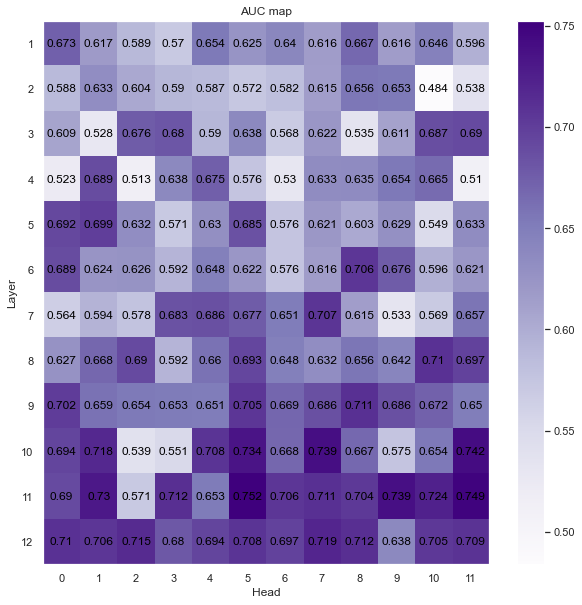

In [8]:
# Construction of the AUC map
auc_map = np.zeros((12,12))
for l in range(12):
    for h in range(12):
        preds = pur_attention[f"layer_{l}"][f"head_{h}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map[l,h] = metrics.auc(fpr, tpr)

# plot the color map
fig = default_plot_colormap(auc_map, xlabel="Head", ylabel="Layer", title="AUC map")
plt.savefig(os.path.join(graph_folder,"auc_map.png"))
plt.show()

We can make here some really interesting comments :

- first the maximum value for the *AUC* on this map is $\approx 0.75$. This is a really high *plausibility score*. The *AUC* provided here is much better than the *AUC* provided by the flow max problem
- for every head of every layer we have an *AUC* greater than $0.5$ this means that every layer provide a plausible explanation (better than a random explanation).
- the layer **11** is really interesting and provide an *AUC* score higher than the other layers (a focus on this layer will be made later).
- the heads with an AUC near $0.5$ provide a useless information. $0.5$ is the worst AUC we can obtain.
- we will retain the head 5 of the layer 11. Then to access the best head we will do attention_tensor[0,10,5], the heads are numbered from 0 to 11 but the layers are numbered from 1 to 12 because in the transformers architecture the layer 0 is the non-contextual embedding layer (that we do not study here).

## HTML visualisation (look deeply into the heads)

---

We will look at the highlighted words and compare it with the e-snli annotation. We want to be convinced that some heads have really no mean in terms of plausibility analysis.

In [9]:
sent_choice = random.randint(0,1000)
print(f">> we will look at the sentence : {sent_choice}")

>> we will look at the sentence : 979


In [10]:
# visualize on the best head
try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score
    attention_score = raw_attention_inst.attention_tensor[0,10,5,:,:].sum(dim=0)
    # noramlization of the score
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)
    # we will now earch the e-snli corresponding sentence
    j = 0

    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
        j += 1

    vis = hightlight_txt(raw_attention_inst.tokens, attention_score)
    display(HTML(vis))
    vis = hightlight_txt(raw_attention_inst.tokens, eval(e_snli_data["hg_goal"][j]))
    display(HTML(vis))

except Exception :
    print("sentences problems")

Good head for the AUC but really sparse we don't have something really interesting for our study

In [11]:
# visualize the worst head
try :
    sent = sentences[sent_choice, :].clone().detach()[None,:]
    mk = masks[sent_choice, :].clone().detach()[None,:]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )

    # construction of the attention score >> here we take the layer 4 and the head 2
    attention_score = raw_attention_inst.attention_tensor[0,3,2,:,:].sum(dim=0)
    # normalization of the score
    attention_score = normalize_attention(raw_attention_inst.tokens, attention_score)
    while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
        j += 1
    # attention visu --> we just multiply by 10 the attention score to see better the colors
    vis = hightlight_txt(raw_attention_inst.tokens, attention_score/0.1)
    display(HTML(vis))
    vis = hightlight_txt(raw_attention_inst.tokens, eval(e_snli_data["hg_goal"][j]))
    display(HTML(vis))

except Exception :
    print("sentences problems")

Here the AUC is really bad and we can see that the annotation is really bad to

In [12]:
# the number of 1 we have in our dataset
# >> we don't mark a lot of data
print(f"ratio of 1 label in e-snli data : {np.round(sum(Y_test)/len(Y_test)*100,3)} %")

ratio of 1 label in e-snli data : 19.32 %


Here also we can make some observation :
- Our hypothesis that some head aren't usefull seems to be true since some heads provide an annotation which is really bad.
- On the other hand some heads seems to be really interesting with an *AUC* $\approx 0.75$, but we have to be really carefull about this because this result is good because of the ratio of 1 label in the Y_test. Since there is a really few number of 1 labels in this, if we have a score that provide very few

## Agregation of the "good" heads

---

After this experience we are able te see that some heads are "useless" (the AUC is really close to 0.5) we will then apply a mask to the head to focus on the head with a good AUC. To define a good AUC we need to set a threshold $TR$, and we will keep all the heads that have an AUC greater than this particular treshold

### Layer Sum agregation

---

We saw during the previous phase that some layers could be pruned be within the "important heads" (the heads we do not prune) each head provide an information different about the plausibility. Our objective is to combine the information gathered by each of these heads. A good way to combine this information is to make the *sum* (sum agregation).

First we will look at the sum layer by layer, we want to keep this approach layer by layer.

In [74]:
if not path.exists(path.join(graph_folder, "layer_agreg")):
    os.mkdir(path.join(graph_folder, "layer_agreg"))

In [76]:
@interact_manual
def layer_combination_TR(TR=(0.5,0.65,0.01)):
    auc_mask = (auc_map >= TR)
    pur_attention_bis = {}
    for l in range(12):
        pur_attention_bis[f"layer_{l}"] = []

    for l in range(12):
        buff = None
        it_1 = True
        for h in range(12):
            if auc_mask[l,h]:
                if it_1 :
                    buff = np.array(pur_attention[f"layer_{l}"][f"head_{h}"])
                    it_1 = False
                else :
                    buff += np.array(pur_attention[f"layer_{l}"][f"head_{h}"])
        pur_attention_bis[f"layer_{l}"] = list(buff)
    # Construction of the AUC map
    auc_map_bis = np.zeros((12,1))
    for l in range(12):
        preds = pur_attention_bis[f"layer_{l}"]
        fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
        auc_map_bis[l,0] = metrics.auc(fpr, tpr)

    # plot the color map
    fig = default_plot_colormap(auc_map_bis, xlabel="ag", ylabel="layer", title="AUC map after agreg")
    plt.savefig(os.path.join(graph_folder,"layer_agreg",f"{TR}.png"))
    plt.show()

interactive(children=(FloatSlider(value=0.5700000000000001, description='TR', max=0.65, min=0.5, step=0.01), B…

### Study of the Layer 11 (push more the threshold)

In [64]:
if not path.exists(path.join(graph_folder, "layer_11")):
    os.mkdir(path.join(graph_folder, "layer_11"))

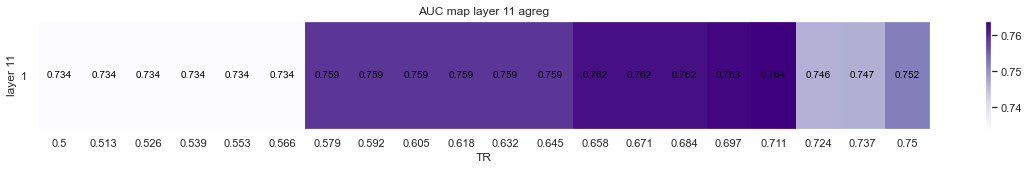

In [77]:
def layer_combination_TR(TR=np.linspace(0.5,0.75,20)):
    map = np.zeros((1,len(TR)))
    k=0
    for tr in TR:
        auc_mask = (auc_map >= tr)
        buff = None
        it_1 = True

        # >> we sum the score of the different heads
        for h in range(12):
            if auc_mask[10,h]:
                if it_1 :
                    buff = np.array(pur_attention[f"layer_{10}"][f"head_{h}"])
                    it_1 = False
                else :
                    buff += np.array(pur_attention[f"layer_{10}"][f"head_{h}"])
        # >> we normalize this score
        buff = (buff - buff.min()) / (buff.max() - buff.min())
        fpr, tpr, threshold = metrics.roc_curve(Y_test, np.array(buff))
        map[0,k] = metrics.auc(fpr, tpr)
        k += 1

    # plot the color map
    fig = default_plot_colormap(map, xlabel="TR", ylabel="layer 11", title="AUC map layer 11 agreg",
                                xstick=[str(np.round(i,3)) for i in TR],
                                sz=(20,2))
    plt.savefig(os.path.join(graph_folder,"layer_11",f"auc_map_l11_tr.png"))

layer_combination_TR()

If we push more the threshold we have a loss of the AUC score (really sparse heads with a very bad information)

#### Creation of the html page for the layer 11 and the best threshold

WARNING : here we have a sentence by sentence reasonning

In [86]:
# load the data
annotations = []

for i in range(sentences.shape[0]):
    buff_dict = {"ESNLI annotation" : None,
                 "AUC annotation": None,
                 "AUC score": 0}

    sent = sentences[i, :].clone().detach()[None, :]
    mk = masks[i, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )


    # the attention_score of the heads
    # we compute the sum of all the scores.
    AS_sent = np.zeros(len(raw_attention_inst.tokens))

    # we combine all the different annotations
    # TODO : revoir l'agregation des têtes.
    for h in range(12):
        # >> apply the mask with the best threshold so far
        if auc_map[10,h] > 0.711 :
            # >> sum the attention weights
            AS_sent += raw_attention_inst.attention_tensor[0,10,h,:,:].sum(dim=0).detach().numpy()
    # >> we normalize the attention weights
    AS_sent = normalize_attention(raw_attention_inst.tokens, torch.tensor(AS_sent)).detach().numpy()
    try :
        j = 0
        while eval(e_snli_data["tok_sent"][j]) != raw_attention_inst.tokens :
            j += 1


        vis = hightlight_txt(raw_attention_inst.tokens, AS_sent/0.1)
        buff_dict["AUC annotation"] = vis

        vis = hightlight_txt(raw_attention_inst.tokens, torch.tensor(eval(e_snli_data["hg_goal"][j])))
        buff_dict["ESNLI annotation"] = vis

        fpr, tpr, threshold = metrics.roc_curve(eval(e_snli_data["hg_goal"][j]), AS_sent)
        auc_score = metrics.auc(fpr, tpr)
        vis = f"{np.round(auc_score,3)*100}"
        buff_dict["AUC score"] = vis

        annotations.append(buff_dict)
    except :
        print("error in the dataset")

table = construct_html_table(list(buff_dict.keys()),
                             annotations)

error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset
error in the dataset


In [87]:
construct_html_page_visu(title="Plausibility for the AUC score metric",
                         table=table,
                         file_name="auc_score_layer_11_tr_711.html"
                         )